In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm_notebook as tqdm
import pandas as pd
import pathlib
from utils import *

# Process results

In [3]:
data_path = pathlib.Path('/home/users/bjornmik/datasets/sweep_10/')

In [4]:
error_trials = compute_error_trials(data_path, n_samples=100)

  0%|          | 0/500 [00:00<?, ?it/s]

In [5]:
errors = compute_errors(data_path)

  0%|          | 0/5 [00:00<?, ?it/s]

In [6]:
errors = compute_error_confidence(errors, error_trials)

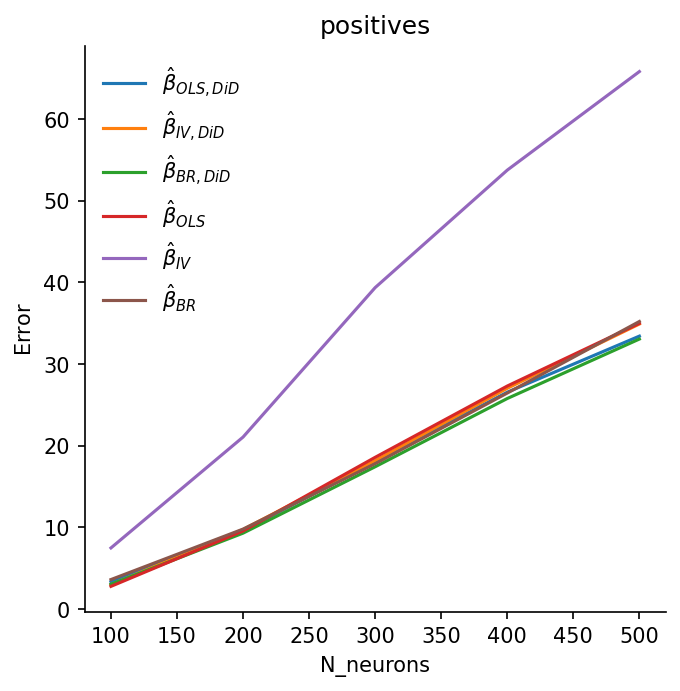

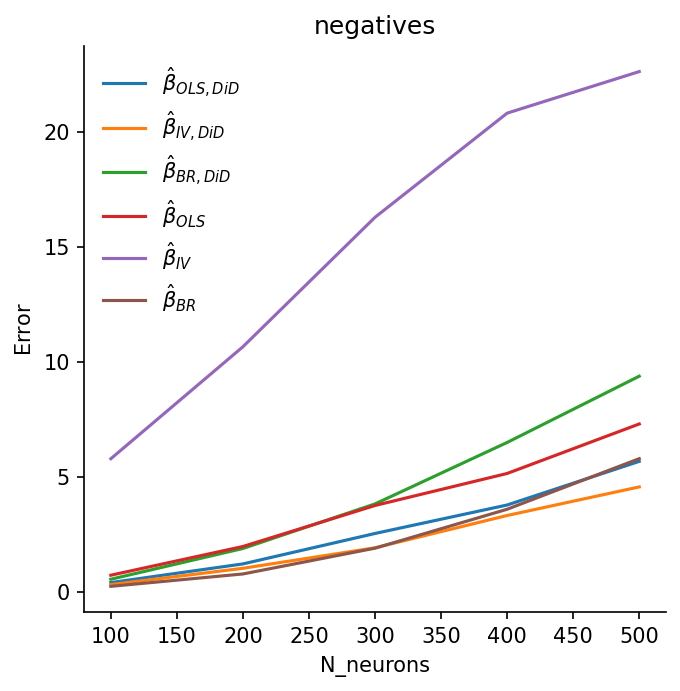

In [7]:
plot_errors(errors, 'n_neurons')

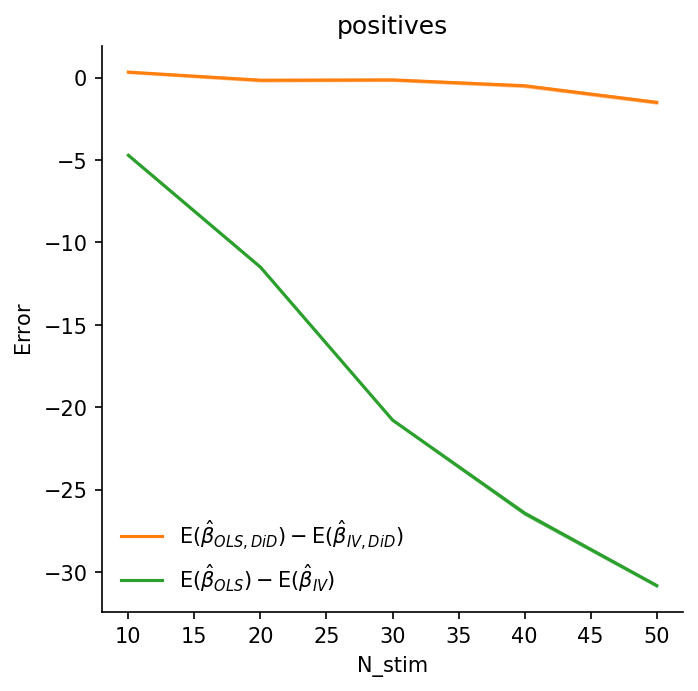

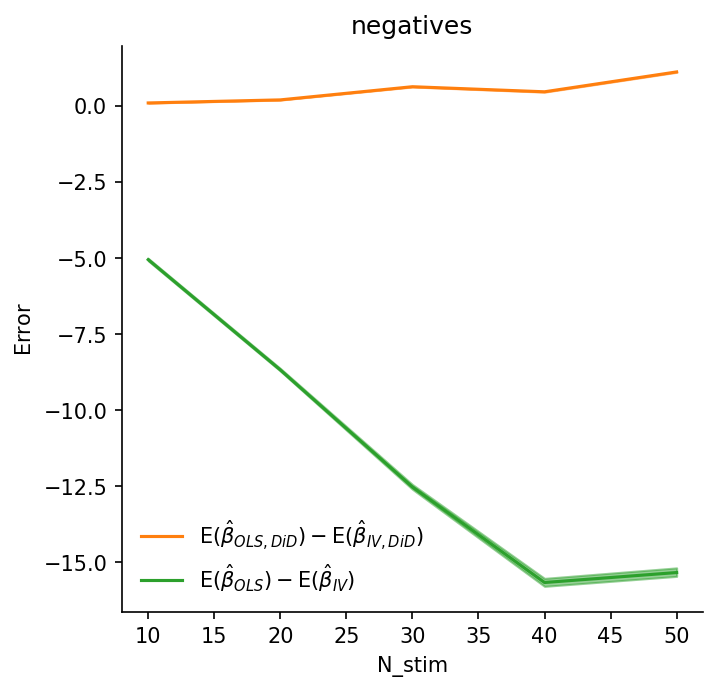

In [8]:
plot_error_difference(errors, 'n_stim')

# Convergence

In [9]:
error_convergence = compute_error_convergence(data_path)

  0%|          | 0/800 [00:00<?, ?it/s]

In [10]:
error_convergence_trials = compute_error_convergence_trials(data_path, n_samples=100)

  0%|          | 0/5000 [00:00<?, ?it/s]

In [11]:
samples = compute_all_samples(data_path)

  0%|          | 0/5 [00:00<?, ?it/s]

In [12]:
index = int(errors['positives'].query('n_neurons==500').index.values)
index

4

In [13]:
errors['positives'].loc[index]

path                          /home/users/bjornmik/datasets/sweep_10/realist...
const                                                                       5.0
n_neurons                                                                 500.0
n_neurons_ex                                                              400.0
n_neurons_in                                                              100.0
                                                    ...                        
error_ols_iv_did_statistic                                                  0.0
error_diff_ols_iv_did                                                 -1.491527
error_diff_ols_iv                                                     -30.83085
error_diff_ols_iv_did_ci               (-1.542395057380802, -1.435960950810638)
error_diff_ols_iv_ci                 (-30.876996341651008, -30.786320671104665)
Name: 4, Length: 62, dtype: object

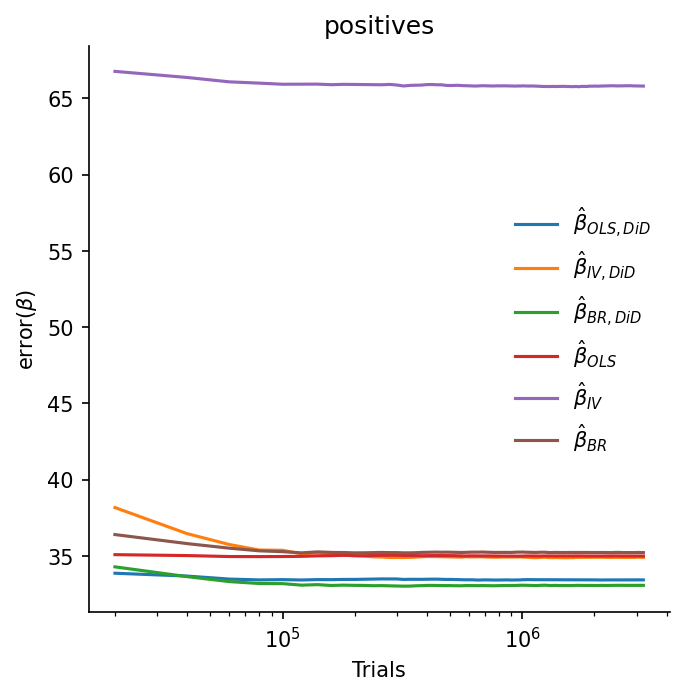

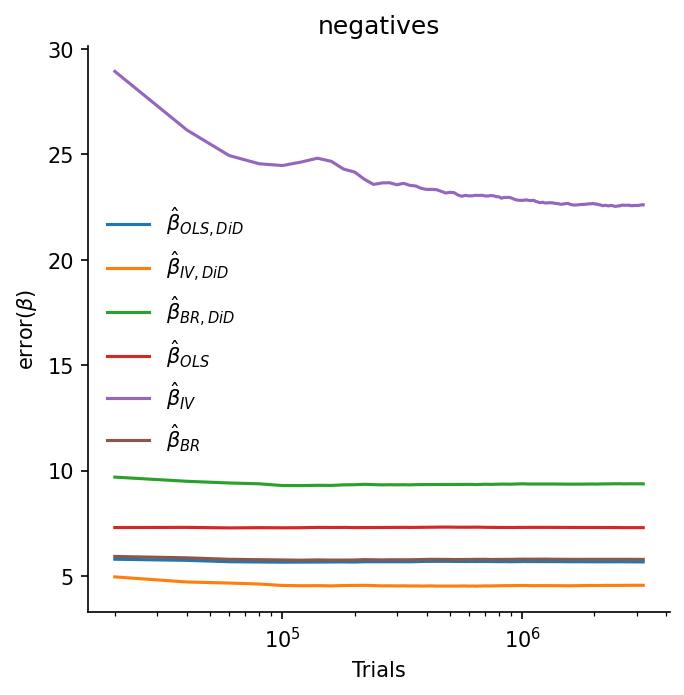

In [14]:
plot_error_convergence(error_convergence, index)

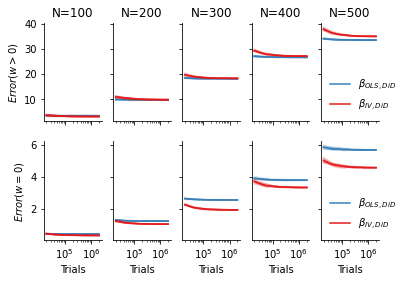

In [15]:
fig, axs = plt.subplots(2, 5, sharex=True, sharey='row')
for i, (n_neurons, df) in enumerate(errors['positives'].groupby('n_neurons')):
    index = int(df.index.values)
    plot_error_convergence_trials( 
        error_convergence_trials, 
        index, 
        keys=['error_beta_ols_did','error_beta_iv_did'], 
        axs=axs.T[i], legend=i==4, xlabels=(False,True), ylabels=[i==0]*2)
    axs[0,i].set_title(f'N={n_neurons:.0f}')

# Regression

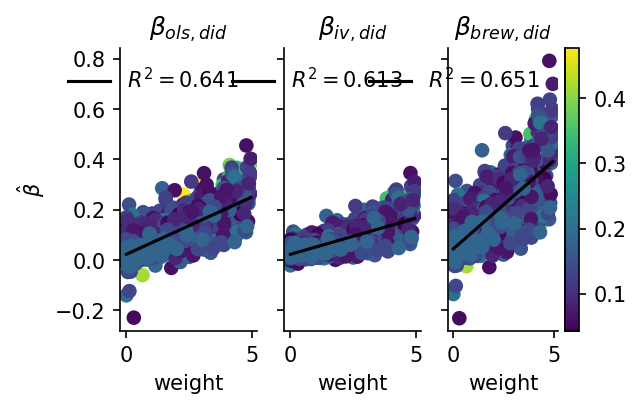

In [16]:
plot_regression(samples, index, ['beta_ols_did','beta_iv_did','beta_brew_did'])

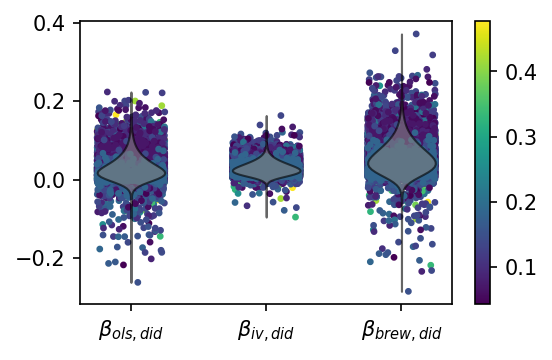

In [17]:
plot_false_positives(samples, index, ['beta_ols_did', 'beta_iv_did', 'beta_brew_did'])